In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')
!pip install tensorflow==1.15
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n!pip install tensorflow==1.15\n"

In [2]:
cd drive/My\ Drive/Projects/ESRNN-GPU/es_rnn

/content/drive/My Drive/Projects/ESRNN-GPU/es_rnn


In [3]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from data_loading import create_datasets, SeriesDataset
from config import get_config
from trainer import ESRNNTrainer
from model import ESRNN
from DRNN import DRNN
import time

In [0]:
import os
import time
import numpy as np
import copy
import torch
import torch.nn as nn
from loss_modules import PinballLoss, sMAPE, np_sMAPE
from utils.logger import Logger
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
print('loading config')
config = get_config('Daily')

loading config


In [0]:
config['input_size'] = 90
config['output_size'] = 90
config['state_hsize'] = 400
config['seasonality'] =  7


In [7]:
print('loading data')
info = pd.read_csv('data/energy_daily.csv')

loading data


In [0]:
train_path = 'data/train/%s-train.csv' % (config['variable'])
test_path = 'data/test/%s-test.csv' % (config['variable'])

In [0]:
df = pd.read_csv('data/energy_daily.csv')

In [0]:
df = df['W']

In [11]:
df.max()

264139.990829977

In [12]:
df.min()

77824.75667106088

In [0]:
#df = (df - df.min())/(df.max() - df.min())

In [0]:
values = df.values

data = []
seq_len = 30
for i in range(len(values)-seq_len+1):
    #print(list(values[i:i+seq_len]))
    data.append(list(values[i:i+seq_len].reshape(-1)))

df = pd.DataFrame(data)

df.head()

In [0]:
train_df = pd.DataFrame(df[:int(0.8*len(df))])
test_df = pd.DataFrame(df[int(0.8*len(df)):])

In [0]:
train_df.to_csv(train_path, index = False)
test_df.to_csv(test_path, index = False)

In [0]:
train = train_df.values.T
test = test_df.values.T

In [18]:
train.shape

(1, 492)

In [19]:
len(train)

1

In [20]:
test.shape

(1, 124)

In [0]:
val = train[:, -config['output_size']:]
train = train[:, :-config['output_size']]

In [22]:
train.shape

(1, 402)

In [23]:
val.shape

(1, 90)

train, val, test = create_datasets(train_path, test_path, config['output_size'])

In [0]:
import torch
from torch.utils.data import Dataset

In [0]:
class SeriesDataset(Dataset):

    def __init__(self, dataTrain, dataVal, dataTest, variable, chop_value, device):
        #dataTrain, mask = chop_series(dataTrain, chop_value)

        #self.dataInfoCatOHE = pd.get_dummies(info[info['SP'] == variable]['category'])
        #self.dataInfoCatHeaders = np.array([i for i in self.dataInfoCatOHE.columns.values])
        #self.dataInfoCat = torch.from_numpy(self.dataInfoCatOHE[mask].values).float()
        self.dataTrain = [torch.tensor(dataTrain[i]) for i in range(len(dataTrain))]  # ALREADY MASKED IN CHOP FUNCTION
        self.dataVal = [torch.tensor(dataVal[i]) for i in range(len(dataVal))]
        self.dataTest = [torch.tensor(dataTest[i]) for i in range(len(dataTest))]
        self.device = device

    def __len__(self):
        return len(self.dataTrain)

    def __getitem__(self, idx):
        return self.dataTrain[idx].to(self.device), \
                self.dataVal[idx].to(self.device), \
                self.dataTest[idx].to(self.device), \
                idx
                #self.dataInfoCat[idx].to(self.device), \

In [0]:
dataset = SeriesDataset(train, val, test, config['variable'], config['chop_val'], config['device'])
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

In [27]:
for batch in dataloader:
    print(batch[0].shape)

torch.Size([1, 402])


In [28]:
len(dataset)

1

In [29]:
run_id = str(int(time.time())) #UNIX time
run_id

'1586512915'

In [30]:
config['dilations']

((1, 3), (7, 9))

In [31]:
for grp_num in range(len(config['dilations'])):
    print(grp_num)

0
1


In [32]:
'''
class ResidualDRNN(nn.Module):
    def __init__(self, config):
        super(ResidualDRNN, self).__init__()
        self.config = config

        layers = []
        for grp_num in range(len(self.config['dilations'])):

            if grp_num == 0:
                input_size = self.config['input_size']# + self.config['num_of_categories']
            else:
                input_size = self.config['state_hsize']
            
            #input_size = self.config['input_size']
            
            l = DRNN(input_size,
                     self.config['state_hsize'],
                     n_layers=len(self.config['dilations'][grp_num]),
                     dilations=self.config['dilations'][grp_num],
                     cell_type=self.config['rnn_cell_type'])

            layers.append(l)

        self.rnn_stack = nn.Sequential(*layers)

    def forward(self, input_data):
        for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            out, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                out += residual
            input_data = out
        return out
'''

"\nclass ResidualDRNN(nn.Module):\n    def __init__(self, config):\n        super(ResidualDRNN, self).__init__()\n        self.config = config\n\n        layers = []\n        for grp_num in range(len(self.config['dilations'])):\n\n            if grp_num == 0:\n                input_size = self.config['input_size']# + self.config['num_of_categories']\n            else:\n                input_size = self.config['state_hsize']\n            \n            #input_size = self.config['input_size']\n            \n            l = DRNN(input_size,\n                     self.config['state_hsize'],\n                     n_layers=len(self.config['dilations'][grp_num]),\n                     dilations=self.config['dilations'][grp_num],\n                     cell_type=self.config['rnn_cell_type'])\n\n            layers.append(l)\n\n        self.rnn_stack = nn.Sequential(*layers)\n\n    def forward(self, input_data):\n        for layer_num in range(len(self.rnn_stack)):\n            residual = input_da

In [0]:
class ESRNN(nn.Module):
    def __init__(self, num_series, config):
        super(ESRNN, self).__init__()
        self.config = config
        self.num_series = num_series
        self.add_nl_layer = self.config['add_nl_layer']

        init_lev_sms = []
        init_seas_sms = []
        init_seasonalities = []

        for i in range(num_series):
            init_lev_sms.append(nn.Parameter(torch.Tensor([0.5]), requires_grad=True))
            init_seas_sms.append(nn.Parameter(torch.Tensor([0.5]), requires_grad=True))
            init_seasonalities.append(nn.Parameter((torch.ones(config['seasonality']) * 0.5), requires_grad=True))

        self.init_lev_sms = nn.ParameterList(init_lev_sms)
        self.init_seas_sms = nn.ParameterList(init_seas_sms)
        self.init_seasonalities = nn.ParameterList(init_seasonalities)

        self.nl_layer = nn.Linear(config['state_hsize'],
                                  config['state_hsize'])
        self.act = nn.Tanh()
        self.scoring = nn.Linear(config['state_hsize'], config['output_size'])

        self.logistic = nn.Sigmoid()

        #self.resid_drnn = ResidualDRNN(self.config)

        layers = []
        for grp_num in range(len(self.config['dilations'])):

            if grp_num == 0:
                input_size = self.config['input_size']# + self.config['num_of_categories']
            else:
                input_size = self.config['state_hsize']
            
            #input_size = self.config['input_size']
            
            l = DRNN(input_size,
                     self.config['state_hsize'],
                     n_layers=len(self.config['dilations'][grp_num]),
                     dilations=self.config['dilations'][grp_num],
                     cell_type=self.config['rnn_cell_type'])

            layers.append(l)

        self.rnn_stack = nn.Sequential(*layers)

    def forward(self, train, val, test, idxs, testing=False):
        # GET THE PER SERIES PARAMETERS
        lev_sms = self.logistic(torch.stack([self.init_lev_sms[idx] for idx in idxs]).squeeze(1))
        seas_sms = self.logistic(torch.stack([self.init_seas_sms[idx] for idx in idxs]).squeeze(1))
        init_seasonalities = torch.stack([self.init_seasonalities[idx] for idx in idxs])

        seasonalities = []
        # PRIME SEASONALITY
        for i in range(self.config['seasonality']):
            seasonalities.append(torch.exp(init_seasonalities[:, i]))
        seasonalities.append(torch.exp(init_seasonalities[:, 0]))

        if testing:
            train = torch.cat((train, val), dim=1)

        train = train.float()

        levs = []
        log_diff_of_levels = []

        levs.append(train[:, 0] / seasonalities[0])
        for i in range(1, train.shape[1]):
            # CALCULATE LEVEL FOR CURRENT TIMESTEP TO NORMALIZE RNN
            new_lev = lev_sms * (train[:, i] / seasonalities[i]) + (1 - lev_sms) * levs[i - 1]
            levs.append(new_lev)

            # STORE DIFFERENCE TO PENALIZE LATER
            log_diff_of_levels.append(torch.log(new_lev / levs[i - 1]))

            # CALCULATE SEASONALITY TO DESEASONALIZE THE DATA FOR RNN
            seasonalities.append(seas_sms * (train[:, i] / new_lev) + (1 - seas_sms) * seasonalities[i])

        seasonalities_stacked = torch.stack(seasonalities).transpose(1, 0)
        levs_stacked = torch.stack(levs).transpose(1, 0)

        loss_mean_sq_log_diff_level = 0
        if self.config['level_variability_penalty'] > 0:
            sq_log_diff = torch.stack(
                [(log_diff_of_levels[i] - log_diff_of_levels[i - 1]) ** 2 for i in range(1, len(log_diff_of_levels))])
            loss_mean_sq_log_diff_level = torch.mean(sq_log_diff)

        if self.config['output_size'] > self.config['seasonality']:
            start_seasonality_ext = seasonalities_stacked.shape[1] - self.config['seasonality']
            end_seasonality_ext = start_seasonality_ext + self.config['output_size'] - self.config['seasonality']
            seasonalities_stacked = torch.cat((seasonalities_stacked, seasonalities_stacked[:, start_seasonality_ext:end_seasonality_ext]),
                                              dim=1)

        window_input_list = []
        window_output_list = []
        for i in range(self.config['input_size'] - 1, train.shape[1]):
            input_window_start = i + 1 - self.config['input_size']
            input_window_end = i + 1

            train_deseas_window_input = train[:, input_window_start:input_window_end] / seasonalities_stacked[:,
                                                                                        input_window_start:input_window_end]
            train_deseas_norm_window_input = (train_deseas_window_input / levs_stacked[:, i].unsqueeze(1))
            #train_deseas_norm_cat_window_input = torch.cat((train_deseas_norm_window_input), dim=1)
            window_input_list.append(train_deseas_norm_window_input)

            output_window_start = i + 1
            output_window_end = i + 1 + self.config['output_size']

            if i < train.shape[1] - self.config['output_size']:
                train_deseas_window_output = train[:, output_window_start:output_window_end] / \
                                             seasonalities_stacked[:, output_window_start:output_window_end]
                train_deseas_norm_window_output = (train_deseas_window_output / levs_stacked[:, i].unsqueeze(1))
                window_output_list.append(train_deseas_norm_window_output)

        window_input = torch.cat([i.unsqueeze(0) for i in window_input_list], dim=0)
        window_output = torch.cat([i.unsqueeze(0) for i in window_output_list], dim=0)

        self.train()
        network_pred = self.series_forward(window_input[:-self.config['output_size']])
        network_act = window_output

       

        self.eval()
        network_output_non_train = self.series_forward(window_input)
        

        # USE THE LAST VALUE OF THE NETWORK OUTPUT TO COMPUTE THE HOLDOUT PREDICTIONS
        hold_out_output_reseas = network_output_non_train[-1] * seasonalities_stacked[:, -self.config['output_size']:]
        hold_out_output_renorm = hold_out_output_reseas * levs_stacked[:, -1].unsqueeze(1)

        hold_out_pred = hold_out_output_renorm * torch.gt(hold_out_output_renorm, 0).float()
        hold_out_act = test if testing else val

        hold_out_act_deseas = hold_out_act.float() / seasonalities_stacked[:, -self.config['output_size']:]
        hold_out_act_deseas_norm = hold_out_act_deseas / levs_stacked[:, -1].unsqueeze(1)

        #print('validation plots')
        #print(network_pred.shape)
        #print(network_act.shape)
        #plt.plot(network_pred.squeeze().mean(dim = 0).detach().cpu(), color = 'red')
        #plt.plot(network_act.squeeze().mean(dim = 0).detach().cpu(), color = 'blue')
        #plt.show()

        self.train()
        # RETURN JUST THE TRAINING INPUT RATHER THAN THE ENTIRE SET BECAUSE THE HOLDOUT IS BEING GENERATED WITH THE REST
        return network_pred, \
               network_act, \
               (hold_out_pred, network_output_non_train), \
               (hold_out_act, hold_out_act_deseas_norm), \
               loss_mean_sq_log_diff_level

    def series_forward(self, data):
        data = self.resid_drnn(data)
        if self.add_nl_layer:
            data = self.nl_layer(data)
            data = self.act(data)
        data = self.scoring(data)
        return data
    
    def resid_drnn(self, input_data):
      for layer_num in range(len(self.rnn_stack)):
            residual = input_data
            out, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                out += residual
            input_data = out
      return out

In [0]:
class ESRNNTrainer(nn.Module):
    def __init__(self, model, dataloader, run_id, config):
        super(ESRNNTrainer, self).__init__()
        self.model = model.to(config['device'])
        self.config = config
        self.dl = dataloader
        #self.ohe_headers = ohe_headers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        # self.optimizer = torch.optim.ASGD(self.model.parameters(), lr=config['learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer,
                                                         step_size=config['lr_anneal_step'],
                                                         gamma=config['lr_anneal_rate'])
        self.criterion = PinballLoss(self.config['training_tau'],
                                     self.config['output_size'] * self.config['batch_size'], self.config['device'])
        self.epochs = 0
        self.max_epochs = 50#config['num_of_train_epochs']
        self.run_id = str(run_id)
        self.prod_str = 'prod' if config['prod'] else 'dev'
        self.log = Logger("../logs/train%s%s%s" % (self.config['variable'], self.prod_str, self.run_id))
        self.csv_save_path = None

    def train_epochs(self):
        max_loss = 1e8
        start_time = time.time()
        for e in range(self.max_epochs):
            self.scheduler.step()

            epoch_loss = self.train()
            if epoch_loss < max_loss:
                self.save()
            epoch_val_loss = self.val()
            if e == 0:
                file_path = os.path.join(self.csv_save_path, 'validation_losses.csv')
                with open(file_path, 'w') as f:
                    f.write('epoch,training_loss,validation_loss\n')
            with open(file_path, 'a') as f:
                f.write(','.join([str(e), str(epoch_loss), str(epoch_val_loss)]) + '\n')
        print('Total Training Mins: %5.2f' % ((time.time()-start_time)/60))
        #epoch_val_loss = self.val(testing=True)

    def train(self):
        self.model.train()
        epoch_loss = 0
        for batch_num, (train, val, test, idx) in enumerate(self.dl):
            start = time.time()
            print("Train_batch: %d" % (batch_num + 1))
            loss = self.train_batch(train, val, test, idx)
            epoch_loss += loss
            end = time.time()
            self.log.log_scalar('Iteration time', end - start, batch_num + 1 * (self.epochs + 1))
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1

        # LOG EPOCH LEVEL INFORMATION
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f' % (
            self.epochs, self.max_epochs, epoch_loss))
        info = {'loss': epoch_loss}

        self.log_values(info)
        self.log_hists()

        return epoch_loss

    def train_batch(self, train, val, test, idx):
        self.optimizer.zero_grad()
        network_pred, network_act, _, _, loss_mean_sq_log_diff_level = self.model(train, val,
                                                                                  test,
                                                                                  idx)
        print('training plots')
        #.mean(dim = 0)
        plt.plot(network_pred.squeeze()[-1, :].detach().cpu(), color = 'red')
        plt.plot(network_act.squeeze()[-1, :].detach().cpu(), color = 'blue')
        plt.show()
        loss = self.criterion(network_pred, network_act)
        loss.backward()
        nn.utils.clip_grad_value_(self.model.parameters(), self.config['gradient_clipping'])
        self.optimizer.step()
        self.scheduler.step()
        return float(loss)

    def val(self, testing = False):
        self.model.eval()
        with torch.no_grad():
            acts = []
            preds = []
            

            hold_out_loss = 0
            for batch_num, (train, val, test, idx) in enumerate(self.dl):
                _, _, (hold_out_pred, network_output_non_train), \
                (hold_out_act, hold_out_act_deseas_norm), _ = self.model(train, val, test, idx, testing = testing)
                hold_out_loss += self.criterion(network_output_non_train.unsqueeze(0).float(),
                                                hold_out_act_deseas_norm.unsqueeze(0).float())
                acts.extend(hold_out_act.view(-1).cpu().detach().numpy())
                preds.extend(hold_out_pred.view(-1).cpu().detach().numpy())
                
            hold_out_loss = hold_out_loss / (batch_num + 1)
            if testing:
              print('FINAL TEST PLOT')
              print('validation plots')
              plt.plot(hold_out_pred.squeeze().detach().cpu(), color = 'red')
              plt.plot(hold_out_act.squeeze().detach().cpu(), color = 'blue')
              plt.show()

              return hold_out_loss.detach().cpu().item()
              
            _hold_out_df = pd.DataFrame({'acts': acts, 'preds': preds})
            #cats = [val for val in self.ohe_headers[info_cat_overall.argmax(axis=1)] for _ in
            #        range(self.config['output_size'])]
            #_hold_out_df['category'] = cats

            overall_hold_out_df = copy.copy(_hold_out_df)
            #overall_hold_out_df['category'] = ['Overall' for _ in cats]

            overall_hold_out_df = pd.concat((_hold_out_df, overall_hold_out_df))
            grouped_results = pd.DataFrame(columns = ['Error'])
            for i in range(len(overall_hold_out_df)):
              row = {'Error': np_sMAPE(overall_hold_out_df.iloc[i].preds, overall_hold_out_df.iloc[i].acts, overall_hold_out_df.iloc[i].shape[0])}
              grouped_results = grouped_results.append(row, ignore_index = True)
            #grouped_results = overall_hold_out_df.apply(lambda x: np_sMAPE(x.preds, x.acts, x.shape[0]))
            #print(grouped_results)

            results = grouped_results.to_dict()
            results['hold_out_loss'] = float(hold_out_loss.detach().cpu())

            #self.log_values(results)

            file_path = os.path.join('..', 'grouped_results', self.run_id, self.prod_str)
            os.makedirs(file_path, exist_ok=True)

            print(results)
            grouped_path = os.path.join(file_path, 'grouped_results-{}.csv'.format(self.epochs))
            grouped_results.to_csv(grouped_path)
            self.csv_save_path = file_path

        return hold_out_loss.detach().cpu().item()

    def save(self, save_dir='..'):
        print('Loss decreased, saving model!')
        file_path = os.path.join(save_dir, 'models', self.run_id, self.prod_str)
        model_path = os.path.join(file_path, 'model-{}.pyt'.format(self.epochs))
        os.makedirs(file_path, exist_ok=True)
        torch.save({'state_dict': self.model.state_dict()}, model_path)

    def log_values(self, info):

        # SCALAR
        for tag, value in info.items():
            self.log.log_scalar(tag, value, self.epochs + 1)

    def log_hists(self):
        # HISTS
        batch_params = dict()
        for tag, value in self.model.named_parameters():
            if value.grad is not None:
                if "init" in tag:
                    name, _ = tag.split(".")
                    if name not in batch_params.keys() or "%s/grad" % name not in batch_params.keys():
                        batch_params[name] = []
                        batch_params["%s/grad" % name] = []
                    batch_params[name].append(value.data.cpu().numpy())
                    batch_params["%s/grad" % name].append(value.grad.cpu().numpy())
                else:
                    tag = tag.replace('.', '/')
                    self.log.log_histogram(tag, value.data.cpu().numpy(), self.epochs + 1)
                    self.log.log_histogram(tag + '/grad', value.grad.data.cpu().numpy(), self.epochs + 1)
            else:
                print('Not printing %s because it\'s not updating' % tag)

        for tag, v in batch_params.items():
            vals = np.concatenate(np.array(v))
            self.log.log_histogram(tag, vals, self.epochs + 1)

In [0]:
model = ESRNN(num_series=len(dataset), config=config)

In [36]:
tr = ESRNNTrainer(model, dataloader, run_id, config)

Train_batch: 1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


training plots


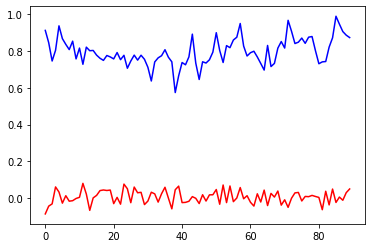


[TRAIN]  Epoch [1/50]   Loss: 187.1447

Loss decreased, saving model!
{'Error': {0: 100.0, 1: 90.3644790649414, 2: 84.3096923828125, 3: 84.52662658691406, 4: 75.3603515625, 5: 89.86133575439453, 6: 75.25582885742188, 7: 77.90853118896484, 8: 93.95719146728516, 9: 93.07174682617188, 10: 85.82331085205078, 11: 81.84425354003906, 12: 81.37718200683594, 13: 96.70664978027344, 14: 89.85321807861328, 15: 92.29906463623047, 16: 86.40706634521484, 17: 78.67284393310547, 18: 82.5396728515625, 19: 71.93000793457031, 20: 83.35371398925781, 21: 84.66864013671875, 22: 100.0, 23: 66.70649719238281, 24: 79.82499694824219, 25: 93.01481628417969, 26: 78.46345520019531, 27: 87.1373519897461, 28: 79.92767333984375, 29: 96.67868041992188, 30: 83.04520416259766, 31: 77.97376251220703, 32: 82.8673095703125, 33: 90.95124053955078, 34: 86.19465637207031, 35: 74.61528015136719, 36: 89.5306167602539, 37: 100.0, 38: 79.66077423095703, 39: 85.9352798461914, 40: 93.9776611328125, 41: 99.82669830322266, 42: 94.554

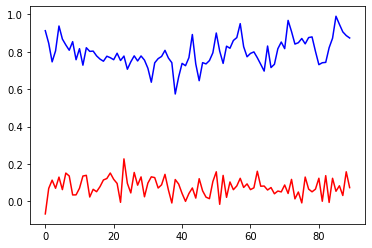

[TRAIN]  Epoch [2/50]   Loss: 173.5759
Loss decreased, saving model!
{'Error': {0: 100.0, 1: 53.920467376708984, 2: 34.84501647949219, 3: 57.779945373535156, 4: 34.3731689453125, 5: 53.528560638427734, 6: 37.28435134887695, 7: 36.64772415161133, 8: 71.51824188232422, 9: 66.7752456665039, 10: 44.24485397338867, 11: 50.500911712646484, 12: 47.22442626953125, 13: 61.60370635986328, 14: 64.10565185546875, 15: 69.9808120727539, 16: 68.2023696899414, 17: 43.442596435546875, 18: 47.20309066772461, 19: 34.35905456542969, 20: 43.95222091674805, 21: 47.835453033447266, 22: 85.31068420410156, 23: 27.047883987426758, 24: 52.27534103393555, 25: 62.435752868652344, 26: 44.3608512878418, 27: 61.47227478027344, 28: 45.43972396850586, 29: 68.5167007446289, 30: 39.98117446899414, 31: 38.3193359375, 32: 50.19503402709961, 33: 57.15319061279297, 34: 65.05662536621094, 35: 37.08585739135742, 36: 64.3714370727539, 37: 82.78722381591797, 38: 50.533748626708984, 39: 70.29731750488281, 40: 68.66859436035156, 4

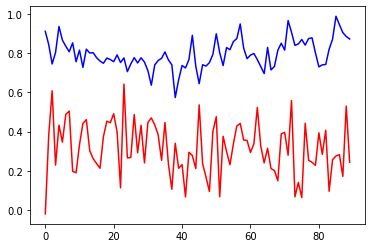

[TRAIN]  Epoch [3/50]   Loss: 130.8413
Loss decreased, saving model!
{'Error': {0: 90.2289810180664, 1: 27.34071922302246, 2: 2.6940412521362305, 3: 29.610034942626953, 4: 6.746678829193115, 5: 25.505388259887695, 6: 8.702715873718262, 7: 7.923574924468994, 8: 46.047611236572266, 9: 40.68752670288086, 10: 14.075371742248535, 11: 23.124008178710938, 12: 24.123239517211914, 13: 34.922576904296875, 14: 39.2164192199707, 15: 44.69125747680664, 16: 46.97819519042969, 17: 18.549169540405273, 18: 18.988731384277344, 19: 8.51330852508545, 20: 17.01107406616211, 21: 19.583202362060547, 22: 65.10121154785156, 23: 1.1485306024551392, 24: 26.58439826965332, 25: 36.571563720703125, 26: 19.56328773498535, 27: 40.471839904785156, 28: 22.211652755737305, 29: 41.05549621582031, 30: 10.085891723632812, 31: 12.81713581085205, 32: 23.551637649536133, 33: 30.680740356445312, 34: 46.8875617980957, 35: 10.358125686645508, 36: 40.53565216064453, 37: 57.95527648925781, 38: 24.581850051879883, 39: 52.4239768981

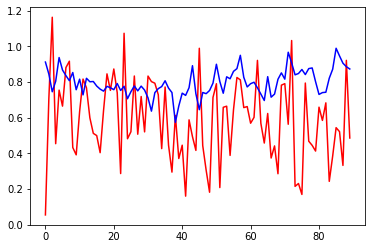

[TRAIN]  Epoch [4/50]   Loss: 85.8397
Loss decreased, saving model!
{'Error': {0: 67.57086181640625, 1: 3.448878526687622, 2: 17.364212036132812, 3: 0.6723910570144653, 4: 14.504703521728516, 5: 0.07172825932502747, 6: 15.196919441223145, 7: 16.49173927307129, 8: 18.931385040283203, 9: 14.222524642944336, 10: 11.099388122558594, 11: 1.365441083908081, 12: 5.084891319274902, 13: 10.185632705688477, 14: 13.252939224243164, 15: 19.34724998474121, 16: 23.89109992980957, 17: 3.4629833698272705, 18: 4.007999897003174, 19: 11.565473556518555, 20: 3.382221221923828, 21: 3.7039835453033447, 22: 39.63227081298828, 23: 14.325729370117188, 24: 2.715749740600586, 25: 14.12539005279541, 26: 1.2468266487121582, 27: 20.223554611206055, 28: 3.3843777179718018, 29: 12.341193199157715, 30: 14.355749130249023, 31: 6.139589309692383, 32: 0.27010828256607056, 33: 6.706717491149902, 34: 25.506513595581055, 35: 10.167089462280273, 36: 17.757944107055664, 37: 26.608871459960938, 38: 0.19949369132518768, 39: 32

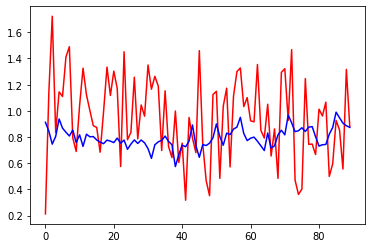

[TRAIN]  Epoch [5/50]   Loss: 66.5954
Loss decreased, saving model!
{'Error': {0: 46.50455856323242, 1: 1.621063470840454, 2: 17.94664764404297, 3: 14.780433654785156, 4: 17.182415008544922, 5: 5.0930609703063965, 6: 17.542383193969727, 7: 19.625003814697266, 8: 3.2520503997802734, 9: 0.45956653356552124, 10: 15.814788818359375, 11: 3.052299737930298, 12: 3.720229387283325, 13: 2.2050225734710693, 14: 1.4488681554794312, 15: 7.307341575622559, 16: 10.488399505615234, 17: 13.39709758758545, 18: 6.081834316253662, 19: 13.370264053344727, 20: 4.307989597320557, 21: 8.16915512084961, 22: 22.44261360168457, 23: 11.973596572875977, 24: 10.603480339050293, 25: 0.13231880962848663, 26: 3.9890284538269043, 27: 7.741579532623291, 28: 1.6704974174499512, 29: 1.9333137273788452, 30: 17.978412628173828, 31: 7.873514175415039, 32: 0.13531257212162018, 33: 2.8550901412963867, 34: 8.284279823303223, 35: 13.695791244506836, 36: 6.674626350402832, 37: 8.252584457397461, 38: 7.650643348693848, 39: 19.649

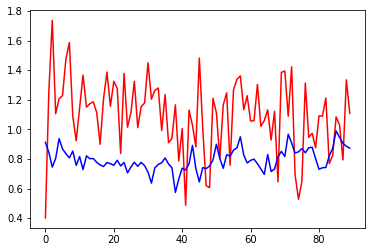

[TRAIN]  Epoch [6/50]   Loss: 64.4885
Loss decreased, saving model!
{'Error': {0: 37.69724655151367, 1: 0.21718616783618927, 2: 14.899624824523926, 3: 15.902070999145508, 4: 14.501187324523926, 5: 3.4883458614349365, 6: 14.965510368347168, 7: 17.74140739440918, 8: 1.0393537282943726, 9: 3.803426504135132, 10: 14.448477745056152, 11: 0.29273468255996704, 12: 5.905942440032959, 13: 2.7660486698150635, 14: 2.782294988632202, 15: 6.206918716430664, 16: 6.493660926818848, 17: 14.282578468322754, 18: 3.9199326038360596, 19: 11.330682754516602, 20: 1.7158806324005127, 21: 7.189277648925781, 22: 16.58841323852539, 23: 7.700207233428955, 24: 13.25544261932373, 25: 3.1335110664367676, 26: 2.113474130630493, 27: 4.794491767883301, 28: 0.6458818912506104, 29: 3.0654444694519043, 30: 16.547317504882812, 31: 5.4409050941467285, 32: 4.260712623596191, 33: 4.928053855895996, 34: 4.048933029174805, 35: 13.253068923950195, 36: 3.406996726989746, 37: 3.4153811931610107, 38: 7.127120494842529, 39: 15.0538

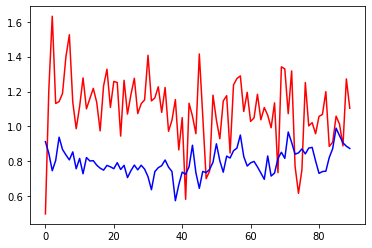

[TRAIN]  Epoch [7/50]   Loss: 58.6753
Loss decreased, saving model!
{'Error': {0: 29.799238204956055, 1: 3.895102024078369, 2: 10.122002601623535, 3: 14.321669578552246, 4: 9.729938507080078, 5: 0.054726045578718185, 6: 10.501856803894043, 7: 14.196266174316406, 8: 1.6067726612091064, 9: 4.937198162078857, 10: 11.325312614440918, 11: 5.752581596374512, 12: 9.44822883605957, 13: 5.106313705444336, 14: 1.5055640935897827, 15: 7.509503364562988, 16: 4.23258638381958, 17: 13.299886703491211, 18: 0.0012887197080999613, 19: 8.17220401763916, 20: 2.4060380458831787, 21: 4.720151424407959, 22: 12.83761215209961, 23: 1.9487278461456299, 24: 13.63998794555664, 25: 4.07259464263916, 26: 1.3647245168685913, 27: 4.035860538482666, 28: 1.943893313407898, 29: 6.84438943862915, 30: 13.393388748168945, 31: 1.3054226636886597, 32: 10.668861389160156, 33: 8.795538902282715, 34: 2.5815789699554443, 35: 11.803095817565918, 36: 1.8143775463104248, 37: 1.7671840190887451, 38: 4.546205520629883, 39: 11.558197

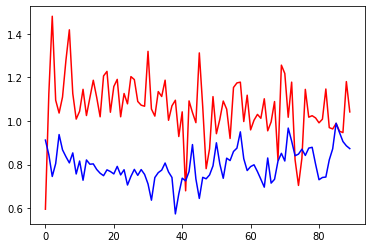

[TRAIN]  Epoch [8/50]   Loss: 50.0240
Loss decreased, saving model!
{'Error': {0: 26.122486114501953, 1: 6.105971336364746, 2: 7.059840679168701, 3: 12.780549049377441, 4: 6.870018005371094, 5: 2.103242874145508, 6: 7.582499027252197, 7: 11.84894847869873, 8: 2.7177836894989014, 9: 4.854114532470703, 10: 9.450827598571777, 11: 9.080724716186523, 12: 11.492924690246582, 13: 6.7520222663879395, 14: 0.054704368114471436, 15: 8.917091369628906, 16: 3.785837173461914, 17: 12.242400169372559, 18: 2.578885555267334, 19: 6.487674236297607, 20: 4.950249671936035, 21: 2.9931092262268066, 22: 12.06401252746582, 23: 1.3091872930526733, 24: 13.065102577209473, 25: 3.869919538497925, 26: 3.5890069007873535, 27: 4.384851932525635, 28: 3.663222074508667, 29: 9.528524398803711, 30: 11.189982414245605, 31: 1.252069115638733, 32: 14.385286331176758, 33: 11.251814842224121, 34: 2.8355956077575684, 35: 10.692912101745605, 36: 1.6980746984481812, 37: 2.0910723209381104, 38: 2.6617207527160645, 39: 10.363409

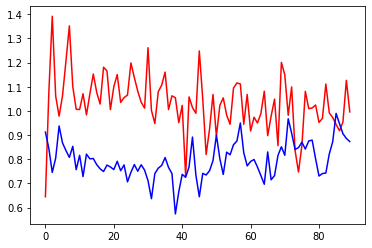

[TRAIN]  Epoch [9/50]   Loss: 45.6119
Loss decreased, saving model!
{'Error': {0: 22.569988250732422, 1: 8.401036262512207, 2: 3.4531712532043457, 3: 10.945493698120117, 4: 3.8769211769104004, 5: 4.4370856285095215, 6: 4.109984874725342, 7: 9.084179878234863, 8: 4.3124260902404785, 9: 4.398406505584717, 10: 7.649747848510742, 11: 12.676599502563477, 12: 13.578839302062988, 13: 8.720440864562988, 14: 1.966180682182312, 15: 10.792713165283203, 16: 3.878330707550049, 17: 10.80206298828125, 18: 5.550990104675293, 19: 4.883553981781006, 20: 7.773744106292725, 21: 0.876640796661377, 22: 12.086446762084961, 23: 4.6838178634643555, 24: 11.972833633422852, 25: 3.200519561767578, 26: 6.09318208694458, 27: 5.249152183532715, 28: 5.634904861450195, 29: 12.636240005493164, 30: 8.500887870788574, 31: 4.005171298980713, 32: 18.167396545410156, 33: 14.004884719848633, 34: 3.7814829349517822, 35: 9.228419303894043, 36: 2.07374906539917, 37: 3.158764600753784, 38: 0.37995603680610657, 39: 9.680503845214

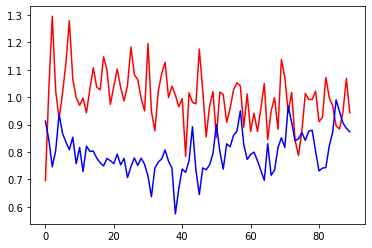

[TRAIN]  Epoch [10/50]   Loss: 41.7043
Loss decreased, saving model!
{'Error': {0: 19.133798599243164, 1: 10.56207275390625, 2: 0.6409386396408081, 3: 9.078320503234863, 4: 1.3273752927780151, 5: 6.643948078155518, 6: 0.19246403872966766, 7: 6.004183769226074, 8: 6.177358150482178, 9: 3.7481625080108643, 10: 6.224040508270264, 11: 16.218549728393555, 12: 15.445939064025879, 13: 10.836381912231445, 14: 4.345908164978027, 15: 12.983282089233398, 16: 4.36707878112793, 17: 9.079835891723633, 18: 8.709024429321289, 19: 3.5495095252990723, 20: 10.722678184509277, 21: 1.5592108964920044, 22: 12.71845817565918, 23: 8.010303497314453, 24: 10.503872871398926, 25: 2.1617207527160645, 26: 8.730138778686523, 27: 6.464702606201172, 28: 7.745871543884277, 29: 15.814826011657715, 30: 5.43989896774292, 31: 6.728469371795654, 32: 21.54369354248047, 33: 16.874305725097656, 34: 5.247658729553223, 35: 7.457644462585449, 36: 2.7992334365844727, 37: 4.744343280792236, 38: 2.193267583847046, 39: 9.47643470764

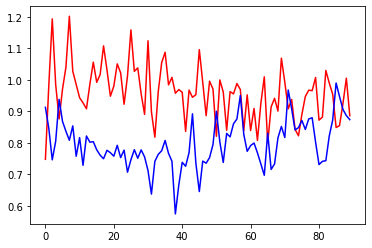

[TRAIN]  Epoch [11/50]   Loss: 38.9451
Loss decreased, saving model!
{'Error': {0: 17.40062141418457, 1: 11.438560485839844, 2: 2.8317830562591553, 3: 8.25928783416748, 4: 0.3701361119747162, 5: 7.5095601081848145, 6: 1.845603585243225, 7: 4.391005039215088, 8: 7.142872333526611, 9: 3.4089226722717285, 10: 5.774357318878174, 11: 17.770204544067383, 12: 16.150981903076172, 13: 11.89238166809082, 14: 5.616708755493164, 15: 14.119108200073242, 16: 4.7204461097717285, 17: 8.126150131225586, 18: 10.255000114440918, 19: 3.085294008255005, 20: 12.146035194396973, 21: 2.864302396774292, 22: 13.235102653503418, 23: 9.495292663574219, 24: 9.695548057556152, 25: 1.4867252111434937, 26: 10.029314041137695, 27: 7.180756568908691, 28: 8.759381294250488, 29: 17.246721267700195, 30: 3.81009578704834, 31: 7.906710147857666, 32: 22.774084091186523, 33: 18.247577667236328, 34: 6.154205322265625, 35: 6.428918361663818, 36: 3.280653715133667, 37: 5.675979137420654, 38: 3.5265274047851562, 39: 9.55862140655

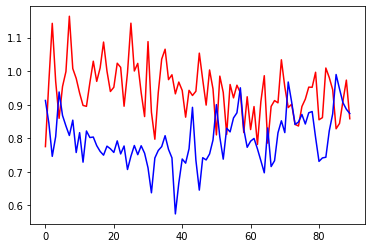

[TRAIN]  Epoch [12/50]   Loss: 38.0609
Loss decreased, saving model!
{'Error': {0: 15.614381790161133, 1: 12.084834098815918, 2: 5.027956485748291, 3: 7.6125054359436035, 4: 0.27643081545829773, 5: 8.11638355255127, 6: 3.789548635482788, 7: 2.7553253173828125, 8: 8.058164596557617, 9: 3.0917327404022217, 10: 5.570804119110107, 11: 19.02676773071289, 12: 16.59860610961914, 13: 12.8839750289917, 14: 6.887731552124023, 15: 15.22373104095459, 16: 5.131164073944092, 17: 7.102325439453125, 18: 11.696881294250488, 19: 2.822401762008667, 20: 13.453346252441406, 21: 4.193655967712402, 22: 13.866435050964355, 23: 10.757550239562988, 24: 8.865195274353027, 25: 0.6852959990501404, 26: 11.269927024841309, 27: 7.980444431304932, 28: 9.652007102966309, 29: 18.407798767089844, 30: 2.1336560249328613, 31: 8.830221176147461, 32: 23.54885482788086, 33: 19.524213790893555, 34: 7.162066459655762, 35: 5.289921760559082, 36: 3.824042558670044, 37: 6.688601493835449, 38: 4.828775882720947, 39: 9.7790546417236

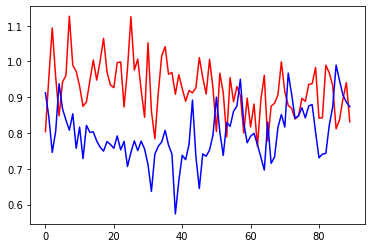

[TRAIN]  Epoch [13/50]   Loss: 37.4623
Loss decreased, saving model!
{'Error': {0: 14.69740104675293, 1: 12.283036231994629, 2: 6.083946704864502, 3: 7.396964073181152, 4: 0.4498484134674072, 5: 8.285560607910156, 6: 4.634708404541016, 7: 1.949644684791565, 8: 8.458391189575195, 9: 2.956544876098633, 10: 5.584536075592041, 11: 19.48229217529297, 12: 16.68756103515625, 13: 13.30827522277832, 14: 7.499443054199219, 15: 15.721528053283691, 16: 5.342564105987549, 17: 6.572096824645996, 18: 12.334548950195312, 19: 2.77164626121521, 20: 14.018268585205078, 21: 4.838491916656494, 22: 14.207056045532227, 23: 11.253270149230957, 24: 8.449830055236816, 25: 0.23372678458690643, 26: 11.83626651763916, 27: 8.404404640197754, 28: 10.016606330871582, 29: 18.82480812072754, 30: 1.2953490018844604, 31: 9.14975357055664, 32: 23.730587005615234, 33: 20.09966278076172, 34: 7.688950061798096, 35: 4.675445556640625, 36: 4.097201824188232, 37: 7.1945319175720215, 38: 5.446342468261719, 39: 9.941170692443848,

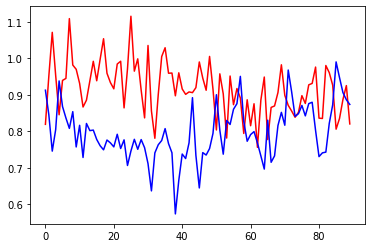

[TRAIN]  Epoch [14/50]   Loss: 37.2438
Loss decreased, saving model!
{'Error': {0: 13.761597633361816, 1: 12.366877555847168, 2: 7.07542085647583, 3: 7.282407760620117, 4: 0.4890395700931549, 5: 8.331467628479004, 6: 5.336019992828369, 7: 1.1655305624008179, 8: 8.799193382263184, 9: 2.845587968826294, 10: 5.697597026824951, 11: 19.778343200683594, 12: 16.65606117248535, 13: 13.657819747924805, 14: 8.071624755859375, 15: 16.14833641052246, 16: 5.54771089553833, 17: 6.040853977203369, 18: 12.880919456481934, 19: 2.7931618690490723, 20: 14.48947811126709, 21: 5.454821586608887, 22: 14.558065414428711, 23: 11.621180534362793, 24: 8.043938636779785, 25: 0.25884318351745605, 26: 12.345040321350098, 27: 8.835936546325684, 28: 10.297088623046875, 29: 19.08742904663086, 30: 0.47520384192466736, 31: 9.339978218078613, 32: 23.731847763061523, 33: 20.59670066833496, 34: 8.228882789611816, 35: 4.02700138092041, 36: 4.360779285430908, 37: 7.680117130279541, 38: 6.015253067016602, 39: 10.134379386901

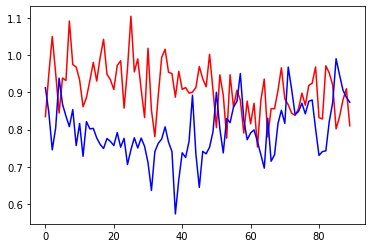

[TRAIN]  Epoch [15/50]   Loss: 37.0518
Loss decreased, saving model!
{'Error': {0: 12.819790840148926, 1: 12.34768295288086, 2: 7.9905524253845215, 3: 7.259640216827393, 4: 0.40449631214141846, 5: 8.269998550415039, 6: 5.889627933502197, 7: 0.41363272070884705, 8: 9.080089569091797, 9: 2.7621498107910156, 10: 5.893314838409424, 11: 19.926300048828125, 12: 16.517675399780273, 13: 13.932744979858398, 14: 8.590834617614746, 15: 16.49549674987793, 16: 5.738819599151611, 17: 5.511898994445801, 18: 13.327341079711914, 19: 2.871356248855591, 20: 14.867573738098145, 21: 6.032238483428955, 22: 14.911694526672363, 23: 11.865318298339844, 24: 7.6566033363342285, 25: 0.7849094271659851, 26: 12.792221069335938, 27: 9.27054214477539, 28: 10.486001968383789, 29: 19.210289001464844, 30: 0.315188467502594, 31: 9.405972480773926, 32: 23.574522018432617, 33: 21.005367279052734, 34: 8.769327163696289, 35: 3.358027696609497, 36: 4.617125511169434, 37: 8.13859748840332, 38: 6.529360771179199, 39: 10.3530693

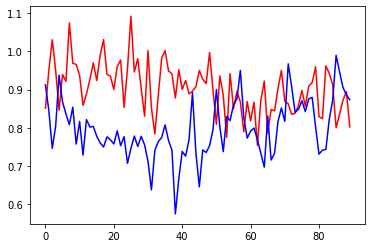

[TRAIN]  Epoch [16/50]   Loss: 36.8751
Loss decreased, saving model!
{'Error': {0: 12.346075057983398, 1: 12.293490409851074, 2: 8.405302047729492, 3: 7.292579174041748, 4: 0.30652883648872375, 5: 8.191879272460938, 6: 6.089450359344482, 7: 0.060281332582235336, 8: 9.190170288085938, 9: 2.7348549365997314, 10: 6.0278849601745605, 11: 19.933757781982422, 12: 16.403438568115234, 13: 14.032832145690918, 14: 8.817776679992676, 15: 16.62510871887207, 16: 5.827816963195801, 17: 5.250414848327637, 18: 13.50201416015625, 19: 2.929690361022949, 20: 15.004616737365723, 21: 6.298006534576416, 22: 15.083538055419922, 23: 11.931891441345215, 24: 7.474867820739746, 25: 1.057610273361206, 26: 12.989124298095703, 27: 9.485478401184082, 28: 10.53508472442627, 29: 19.208255767822266, 30: 0.6916385889053345, 31: 9.384105682373047, 32: 23.42728042602539, 33: 21.160451889038086, 34: 9.0383882522583, 35: 3.01654314994812, 36: 4.736769676208496, 37: 8.344944953918457, 38: 6.750442028045654, 39: 10.4723930358

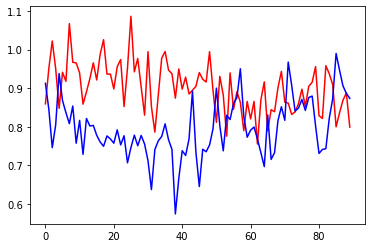

[TRAIN]  Epoch [17/50]   Loss: 36.7850
Loss decreased, saving model!
{'Error': {0: 11.869174003601074, 1: 12.201129913330078, 2: 8.778480529785156, 3: 7.365356922149658, 4: 0.1593569815158844, 5: 8.073566436767578, 6: 6.21769905090332, 7: 0.27036958932876587, 8: 9.272676467895508, 9: 2.721198320388794, 10: 6.194197654724121, 11: 19.882709503173828, 12: 16.25199317932129, 13: 14.097769737243652, 14: 9.014182090759277, 15: 16.7142333984375, 16: 5.910552024841309, 17: 4.992551326751709, 18: 13.63095760345459, 19: 3.003044605255127, 20: 15.093710899353027, 21: 6.538005352020264, 22: 15.250232696533203, 23: 11.948917388916016, 24: 7.309121608734131, 25: 1.3354026079177856, 26: 13.158787727355957, 27: 9.695476531982422, 28: 10.542685508728027, 29: 19.150678634643555, 30: 1.0463532209396362, 31: 9.313445091247559, 32: 23.220304489135742, 33: 21.268003463745117, 34: 9.304655075073242, 35: 2.6713247299194336, 36: 4.847289085388184, 37: 8.52731990814209, 38: 6.935153007507324, 39: 10.59823894500

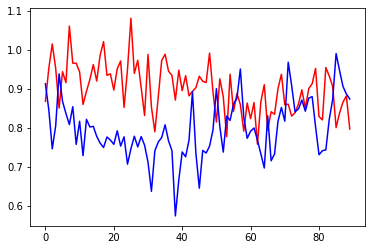

[TRAIN]  Epoch [18/50]   Loss: 36.6862
Loss decreased, saving model!
{'Error': {0: 11.632325172424316, 1: 12.138555526733398, 2: 8.944960594177246, 3: 7.41982889175415, 4: 0.06426850706338882, 5: 7.997697830200195, 6: 6.249607086181641, 7: 0.42488014698028564, 8: 9.301955223083496, 9: 2.7206008434295654, 10: 6.2906951904296875, 11: 19.831178665161133, 12: 16.159955978393555, 13: 14.11263370513916, 14: 9.097125053405762, 15: 16.740169525146484, 16: 5.947775363922119, 17: 4.865790367126465, 18: 13.674714088439941, 19: 3.04634165763855, 20: 15.116373062133789, 21: 6.643911361694336, 22: 15.330378532409668, 23: 11.935361862182617, 24: 7.234030246734619, 25: 1.4759414196014404, 26: 13.230138778686523, 27: 9.796757698059082, 28: 10.527679443359375, 29: 19.097837448120117, 30: 1.2122570276260376, 31: 9.257142066955566, 32: 23.090595245361328, 33: 21.299606323242188, 34: 9.43437385559082, 35: 2.4978742599487305, 36: 4.897690773010254, 37: 8.606289863586426, 38: 7.009045600891113, 39: 10.661905

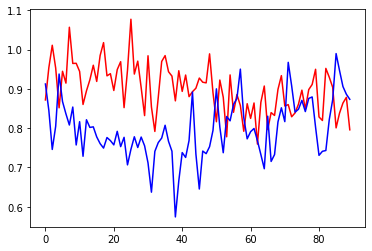

[TRAIN]  Epoch [19/50]   Loss: 36.6326
Loss decreased, saving model!
{'Error': {0: 11.396690368652344, 1: 12.062003135681152, 2: 9.092914581298828, 3: 7.490453243255615, 4: 0.050166551023721695, 5: 7.906773090362549, 6: 6.252592086791992, 7: 0.5691167116165161, 8: 9.320535659790039, 9: 2.7257585525512695, 10: 6.398523807525635, 11: 19.75637435913086, 12: 16.055368423461914, 13: 14.111468315124512, 14: 9.165657043457031, 15: 16.749486923217773, 16: 5.980705738067627, 17: 4.741981029510498, 18: 13.699584007263184, 19: 3.095642566680908, 20: 15.119507789611816, 21: 6.73650598526001, 22: 15.407594680786133, 23: 11.902115821838379, 24: 7.166064739227295, 25: 1.6178369522094727, 26: 13.28897476196289, 27: 9.894074440002441, 28: 10.497249603271484, 29: 19.02364730834961, 30: 1.3670904636383057, 31: 9.183565139770508, 32: 22.9379825592041, 33: 21.310962677001953, 34: 9.560934066772461, 35: 2.323859453201294, 36: 4.9430317878723145, 37: 8.674064636230469, 38: 7.065937519073486, 39: 10.725320816

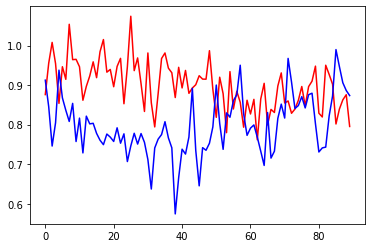

[TRAIN]  Epoch [20/50]   Loss: 36.5737
Loss decreased, saving model!
{'Error': {0: 11.161865234375, 1: 11.973699569702148, 2: 9.222254753112793, 3: 7.575465202331543, 4: 0.18103331327438354, 5: 7.802461624145508, 6: 6.229100704193115, 7: 0.7031524777412415, 8: 9.329323768615723, 9: 2.7358148097991943, 10: 6.5149970054626465, 11: 19.661697387695312, 12: 15.939530372619629, 13: 14.09591007232666, 14: 9.220840454101562, 15: 16.74380874633789, 16: 6.009298324584961, 17: 4.621089458465576, 18: 13.707656860351562, 19: 3.1503162384033203, 20: 15.10483169555664, 21: 6.816224575042725, 22: 15.482192039489746, 23: 11.850799560546875, 24: 7.106061935424805, 25: 1.7606526613235474, 26: 13.33653450012207, 27: 9.986817359924316, 28: 10.45261287689209, 29: 18.93058204650879, 30: 1.5111627578735352, 31: 9.095267295837402, 32: 22.765422821044922, 33: 21.303796768188477, 34: 9.683940887451172, 35: 2.149899959564209, 36: 4.984009265899658, 37: 8.731075286865234, 38: 7.105737209320068, 39: 10.788544654846

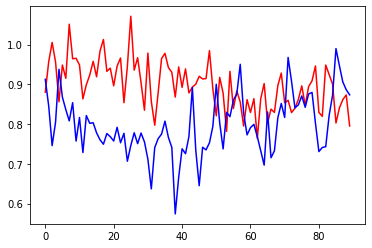

[TRAIN]  Epoch [21/50]   Loss: 36.5105
Loss decreased, saving model!
{'Error': {0: 11.044842720031738, 1: 11.924389839172363, 2: 9.278336524963379, 3: 7.624267578125, 4: 0.25361740589141846, 5: 7.744497299194336, 6: 6.205449104309082, 7: 0.7654074430465698, 8: 9.329148292541504, 9: 2.743121385574341, 10: 6.577005386352539, 11: 19.605815887451172, 12: 15.876700401306152, 13: 14.082010269165039, 14: 9.242287635803223, 15: 16.73410415649414, 16: 6.021651268005371, 17: 4.562312602996826, 18: 13.704052925109863, 19: 3.1788811683654785, 20: 15.089394569396973, 21: 6.850263595581055, 22: 15.517827987670898, 23: 11.817112922668457, 24: 7.080804347991943, 25: 1.8320143222808838, 26: 13.354950904846191, 27: 10.03113842010498, 28: 10.424290657043457, 29: 18.875669479370117, 30: 1.5781025886535645, 31: 9.044441223144531, 32: 22.670217514038086, 33: 21.291763305664062, 34: 9.743736267089844, 35: 2.06329345703125, 36: 5.00277042388916, 37: 8.754341125488281, 38: 7.117988109588623, 39: 10.82023429870

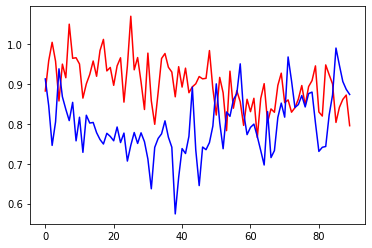

[TRAIN]  Epoch [22/50]   Loss: 36.4768
Loss decreased, saving model!
{'Error': {0: 10.928220748901367, 1: 11.870424270629883, 2: 9.326506614685059, 3: 7.678670406341553, 4: 0.3326787054538727, 5: 7.681600093841553, 6: 6.171106338500977, 7: 0.823320746421814, 8: 9.324930191040039, 9: 2.752476692199707, 10: 6.642147064208984, 11: 19.542190551757812, 12: 15.80941104888916, 13: 14.062817573547363, 14: 9.258179664611816, 15: 16.718114852905273, 16: 6.0322794914245605, 17: 4.504982948303223, 18: 13.693549156188965, 19: 3.20817494392395, 20: 15.066788673400879, 21: 6.878995895385742, 22: 15.551875114440918, 23: 11.776183128356934, 24: 7.059787273406982, 25: 1.9034227132797241, 26: 13.368706703186035, 27: 10.07365608215332, 28: 10.39040470123291, 29: 18.813472747802734, 30: 1.6399874687194824, 31: 8.987669944763184, 32: 22.567289352416992, 33: 21.272062301635742, 34: 9.80198860168457, 35: 1.9774224758148193, 36: 5.020086765289307, 37: 8.77279281616211, 38: 7.123016357421875, 39: 10.85197925567

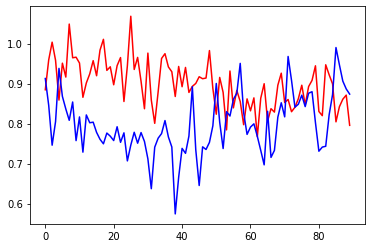

[TRAIN]  Epoch [23/50]   Loss: 36.4410
Loss decreased, saving model!
{'Error': {0: 10.869990348815918, 1: 11.841422080993652, 2: 9.346912384033203, 3: 7.708374977111816, 4: 0.37519681453704834, 5: 7.647988319396973, 6: 6.149080753326416, 7: 0.8503165245056152, 8: 9.321013450622559, 9: 2.758070707321167, 10: 6.676121711730957, 11: 19.506938934326172, 12: 15.773823738098145, 13: 14.0508394241333, 14: 9.263548851013184, 15: 16.7072696685791, 16: 6.036741733551025, 17: 4.477100849151611, 18: 13.685111999511719, 19: 3.2232210636138916, 20: 15.052220344543457, 21: 6.890936374664307, 22: 15.56823444366455, 23: 11.752433776855469, 24: 7.051419258117676, 25: 1.939052939414978, 26: 13.373422622680664, 27: 10.09402084350586, 28: 10.370951652526855, 29: 18.779247283935547, 30: 1.668617844581604, 31: 8.956557273864746, 32: 22.51236343383789, 33: 21.25867462158203, 34: 9.830406188964844, 35: 1.935112714767456, 36: 5.028041839599609, 37: 8.779823303222656, 38: 7.122201442718506, 39: 10.86776447296142

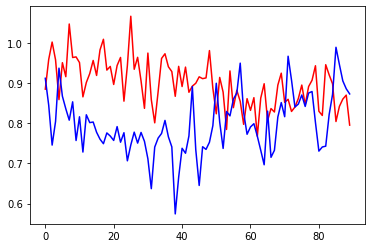

[TRAIN]  Epoch [24/50]   Loss: 36.4220
Loss decreased, saving model!
{'Error': {0: 10.811763763427734, 1: 11.810494422912598, 2: 9.363875389099121, 3: 7.740318775177002, 4: 0.4204168915748596, 5: 7.61249303817749, 6: 6.122635364532471, 7: 0.8754429221153259, 8: 9.315380096435547, 9: 2.7645111083984375, 10: 6.711464881896973, 11: 19.468507766723633, 12: 15.736601829528809, 13: 14.036657333374023, 14: 9.266554832458496, 15: 16.693822860717773, 16: 6.040415287017822, 17: 4.450000762939453, 18: 13.673830032348633, 19: 3.2384893894195557, 20: 15.034675598144531, 21: 6.9006876945495605, 22: 15.583996772766113, 23: 11.72566032409668, 24: 7.044978618621826, 25: 1.974595546722412, 26: 13.376161575317383, 27: 10.113651275634766, 28: 10.349396705627441, 29: 18.742111206054688, 30: 1.6950851678848267, 31: 8.923075675964355, 32: 22.45420265197754, 33: 21.24222755432129, 34: 9.858200073242188, 35: 1.8933043479919434, 36: 5.035445213317871, 37: 8.784854888916016, 38: 7.118370532989502, 39: 10.8833980

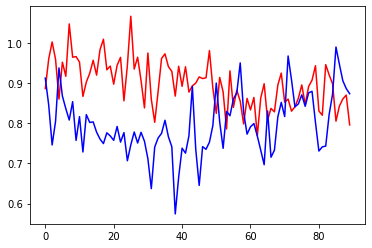

[TRAIN]  Epoch [25/50]   Loss: 36.4023
Loss decreased, saving model!
{'Error': {0: 10.753865242004395, 1: 11.777889251708984, 2: 9.377830505371094, 3: 7.77426290512085, 4: 0.46811574697494507, 5: 7.575216770172119, 6: 6.092227935791016, 7: 0.8989505767822266, 8: 9.30825424194336, 9: 2.771782636642456, 10: 6.747992992401123, 11: 19.427270889282227, 12: 15.69793701171875, 13: 14.020512580871582, 14: 9.267495155334473, 15: 16.678096771240234, 16: 6.043356895446777, 17: 4.423513889312744, 18: 13.65991497039795, 19: 3.2539796829223633, 20: 15.014490127563477, 21: 6.908390045166016, 22: 15.599266052246094, 23: 11.6961669921875, 24: 7.040312767028809, 25: 2.0100860595703125, 26: 13.377178192138672, 27: 10.132440567016602, 28: 10.326050758361816, 29: 18.70244026184082, 30: 1.7195621728897095, 31: 8.887462615966797, 32: 22.39349365234375, 33: 21.22309112548828, 34: 9.885390281677246, 35: 1.85209321975708, 36: 5.042296409606934, 37: 8.788042068481445, 38: 7.111910820007324, 39: 10.89905357360839

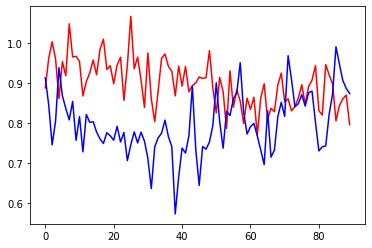

[TRAIN]  Epoch [26/50]   Loss: 36.3818
Loss decreased, saving model!
{'Error': {0: 10.72500228881836, 1: 11.760787963867188, 2: 9.383390426635742, 3: 7.792093753814697, 4: 0.49306926131248474, 5: 7.55587911605835, 6: 6.075173854827881, 7: 0.9099907875061035, 8: 9.303999900817871, 9: 2.775810956954956, 10: 6.766825199127197, 11: 19.405309677124023, 12: 15.677926063537598, 13: 14.011629104614258, 14: 9.26701545715332, 15: 16.669105529785156, 16: 6.044532299041748, 17: 4.410583019256592, 18: 13.651758193969727, 19: 3.261821985244751, 20: 15.003211975097656, 21: 6.911367416381836, 22: 15.6066312789917, 23: 11.680145263671875, 24: 7.038808822631836, 25: 2.027752161026001, 26: 13.376911163330078, 27: 10.141416549682617, 28: 10.313542366027832, 29: 18.681438446044922, 30: 1.7309380769729614, 31: 8.868650436401367, 32: 22.361955642700195, 33: 21.212324142456055, 34: 9.89870548248291, 35: 1.831856608390808, 36: 5.045470237731934, 37: 8.788792610168457, 38: 7.107480525970459, 39: 10.906856536865

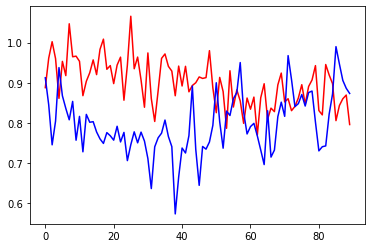

[TRAIN]  Epoch [27/50]   Loss: 36.3712
Loss decreased, saving model!
{'Error': {0: 10.696174621582031, 1: 11.743010520935059, 2: 9.387710571289062, 3: 7.810678482055664, 4: 0.5190762877464294, 5: 7.535921096801758, 6: 6.056496620178223, 7: 0.9202888011932373, 8: 9.299093246459961, 9: 2.780123710632324, 10: 6.7861647605896, 11: 19.382230758666992, 12: 15.657374382019043, 13: 14.001970291137695, 14: 9.265605926513672, 15: 16.6591739654541, 16: 6.0454230308532715, 17: 4.397931098937988, 18: 13.642477989196777, 19: 3.2697393894195557, 20: 14.990878105163574, 21: 6.9135212898254395, 22: 15.613821029663086, 23: 11.663015365600586, 24: 7.038035869598389, 25: 2.045471668243408, 26: 13.37592887878418, 27: 10.150084495544434, 28: 10.30033016204834, 29: 18.659473419189453, 30: 1.741505742073059, 31: 8.848967552185059, 32: 22.329397201538086, 33: 21.200443267822266, 34: 9.911761283874512, 35: 1.811944842338562, 36: 5.048460006713867, 37: 8.788792610168457, 38: 7.101995468139648, 39: 10.91464710235

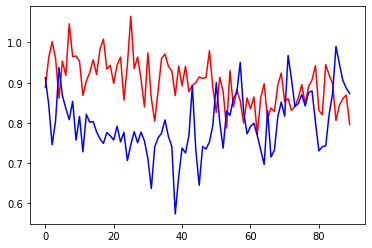

[TRAIN]  Epoch [28/50]   Loss: 36.3603
Loss decreased, saving model!
{'Error': {0: 10.681787490844727, 1: 11.733786582946777, 2: 9.389240264892578, 3: 7.8203020095825195, 4: 0.5325488448143005, 5: 7.5256667137146, 6: 6.046430587768555, 7: 0.9251786470413208, 8: 9.296331405639648, 9: 2.782480001449585, 10: 6.796055793762207, 11: 19.370153427124023, 12: 15.646817207336426, 13: 13.996803283691406, 14: 9.264507293701172, 15: 16.65375518798828, 16: 6.045704364776611, 17: 4.391793251037598, 18: 13.637383460998535, 19: 3.2737433910369873, 20: 14.98416805267334, 21: 6.914182186126709, 22: 15.617315292358398, 23: 11.653884887695312, 24: 7.038008213043213, 25: 2.0543456077575684, 26: 13.375121116638184, 27: 10.154236793518066, 28: 10.293335914611816, 29: 18.648040771484375, 30: 1.7464438676834106, 31: 8.838706970214844, 32: 22.312726974487305, 33: 21.193973541259766, 34: 9.918183326721191, 35: 1.8022160530090332, 36: 5.049901008605957, 37: 8.788435935974121, 38: 7.098804473876953, 39: 10.9185266

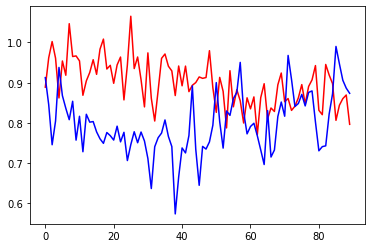

[TRAIN]  Epoch [29/50]   Loss: 36.3547
Loss decreased, saving model!
{'Error': {0: 10.667470932006836, 1: 11.724275588989258, 2: 9.390328407287598, 3: 7.830263137817383, 4: 0.5464333295822144, 5: 7.515140533447266, 6: 6.035635471343994, 7: 0.9298281669616699, 8: 9.293292045593262, 9: 2.7849478721618652, 10: 6.806148529052734, 11: 19.357563018798828, 12: 15.63606071472168, 13: 13.991364479064941, 14: 9.263040542602539, 15: 16.64796257019043, 16: 6.045914649963379, 17: 4.385770320892334, 18: 13.631783485412598, 19: 3.2777819633483887, 20: 14.977028846740723, 21: 6.914565086364746, 22: 15.620652198791504, 23: 11.644290924072266, 24: 7.038270473480225, 25: 2.0631442070007324, 26: 13.373991966247559, 27: 10.158265113830566, 28: 10.28604793548584, 29: 18.63622283935547, 30: 1.7510496377944946, 31: 8.828109741210938, 32: 22.295652389526367, 33: 21.187057495117188, 34: 9.924544334411621, 35: 1.792622685432434, 36: 5.051239013671875, 37: 8.787773132324219, 38: 7.09513521194458, 39: 10.922411918

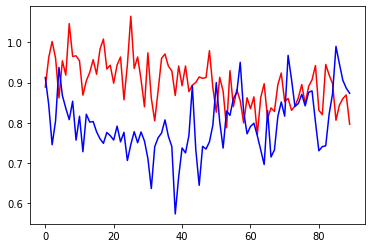

[TRAIN]  Epoch [30/50]   Loss: 36.3489
Loss decreased, saving model!
{'Error': {0: 10.653132438659668, 1: 11.714531898498535, 2: 9.390914916992188, 3: 7.840515613555908, 4: 0.5607066750526428, 5: 7.504417896270752, 6: 6.024303436279297, 7: 0.9341390132904053, 8: 9.290045738220215, 9: 2.787515878677368, 10: 6.8164167404174805, 11: 19.344585418701172, 12: 15.625069618225098, 13: 13.985599517822266, 14: 9.26125717163086, 15: 16.641742706298828, 16: 6.046046733856201, 17: 4.379853248596191, 18: 13.62575912475586, 19: 3.2818610668182373, 20: 14.969497680664062, 21: 6.914612770080566, 22: 15.62387752532959, 23: 11.634270668029785, 24: 7.038812160491943, 25: 2.0719621181488037, 26: 13.372659683227539, 27: 10.16215705871582, 28: 10.278461456298828, 29: 18.624000549316406, 30: 1.7553892135620117, 31: 8.817146301269531, 32: 22.278257369995117, 33: 21.179672241210938, 34: 9.93077564239502, 35: 1.7831875085830688, 36: 5.0525031089782715, 37: 8.78680419921875, 38: 7.091071605682373, 39: 10.92631721

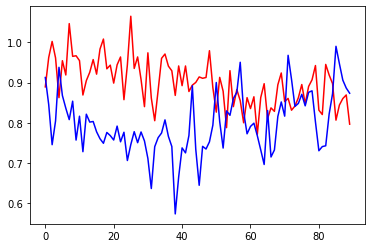

[TRAIN]  Epoch [31/50]   Loss: 36.3430
Loss decreased, saving model!
{'Error': {0: 10.645938873291016, 1: 11.709492683410645, 2: 9.390947341918945, 3: 7.845772743225098, 4: 0.5680287480354309, 5: 7.498917102813721, 6: 6.018336772918701, 7: 0.9362437725067139, 8: 9.288322448730469, 9: 2.788867473602295, 10: 6.821650981903076, 11: 19.337888717651367, 12: 15.619461059570312, 13: 13.982586860656738, 14: 9.26020336151123, 15: 16.638471603393555, 16: 6.046069145202637, 17: 4.376966953277588, 18: 13.622562408447266, 19: 3.283921241760254, 20: 14.965522766113281, 21: 6.91447114944458, 22: 15.62548542022705, 23: 11.629063606262207, 24: 7.039233207702637, 25: 2.076335906982422, 26: 13.371822357177734, 27: 10.164050102233887, 28: 10.274518966674805, 29: 18.617733001708984, 30: 1.7573986053466797, 31: 8.811516761779785, 32: 22.269330978393555, 33: 21.17576789855957, 34: 9.933798789978027, 35: 1.7785539627075195, 36: 5.05305290222168, 37: 8.786212921142578, 38: 7.088891983032227, 39: 10.92819690704

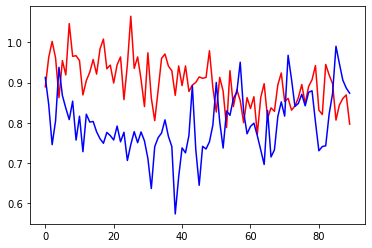

[TRAIN]  Epoch [32/50]   Loss: 36.3400
Loss decreased, saving model!
{'Error': {0: 10.638738632202148, 1: 11.704366683959961, 2: 9.390819549560547, 3: 7.851182460784912, 4: 0.5755120515823364, 5: 7.493304252624512, 6: 6.012130260467529, 7: 0.9381711483001709, 8: 9.286452293395996, 9: 2.7902801036834717, 10: 6.826958656311035, 11: 19.330955505371094, 12: 15.613736152648926, 13: 13.979433059692383, 14: 9.258981704711914, 15: 16.63507652282715, 16: 6.046038627624512, 17: 4.3741302490234375, 18: 13.619157791137695, 19: 3.2860054969787598, 20: 14.961363792419434, 21: 6.914216995239258, 22: 15.627060890197754, 23: 11.623680114746094, 24: 7.0397539138793945, 25: 2.0807929039001465, 26: 13.37092399597168, 27: 10.16588306427002, 28: 10.270464897155762, 29: 18.61127281188965, 30: 1.7593296766281128, 31: 8.805787086486816, 32: 22.260299682617188, 33: 21.171709060668945, 34: 9.936905860900879, 35: 1.7740020751953125, 36: 5.05364465713501, 37: 8.7854585647583, 38: 7.0865325927734375, 39: 10.9301700

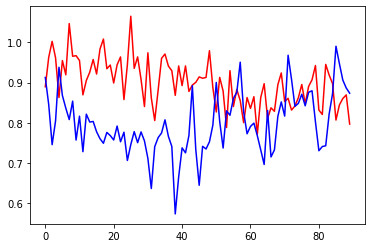

[TRAIN]  Epoch [33/50]   Loss: 36.3370
Loss decreased, saving model!
{'Error': {0: 10.635140419006348, 1: 11.70174503326416, 2: 9.390665054321289, 3: 7.853938579559326, 4: 0.5793664455413818, 5: 7.490463733673096, 6: 6.008877754211426, 7: 0.9390587210655212, 8: 9.2854585647583, 9: 2.79097318649292, 10: 6.829669952392578, 11: 19.327423095703125, 12: 15.61082649230957, 13: 13.977782249450684, 14: 9.258322715759277, 15: 16.63327980041504, 16: 6.046004772186279, 17: 4.372763633728027, 18: 13.617385864257812, 19: 3.2870285511016846, 20: 14.959203720092773, 21: 6.914034366607666, 22: 15.627792358398438, 23: 11.620834350585938, 24: 7.040091514587402, 25: 2.082986354827881, 26: 13.370399475097656, 27: 10.166779518127441, 28: 10.268389701843262, 29: 18.608001708984375, 30: 1.7602227926254272, 31: 8.80282974243164, 32: 22.25572967529297, 33: 21.169628143310547, 34: 9.938395500183105, 35: 1.7717143297195435, 36: 5.0538787841796875, 37: 8.785055160522461, 38: 7.085235595703125, 39: 10.931135177612

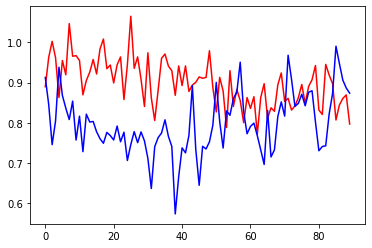

[TRAIN]  Epoch [34/50]   Loss: 36.3354
Loss decreased, saving model!
{'Error': {0: 10.631576538085938, 1: 11.699090003967285, 2: 9.390438079833984, 3: 7.856780052185059, 4: 0.5832546949386597, 5: 7.487565040588379, 6: 6.005537033081055, 7: 0.9399874806404114, 8: 9.284464836120605, 9: 2.7917544841766357, 10: 6.832387924194336, 11: 19.323843002319336, 12: 15.607905387878418, 13: 13.976134300231934, 14: 9.257596969604492, 15: 16.631389617919922, 16: 6.045959949493408, 17: 4.371346950531006, 18: 13.61555004119873, 19: 3.288027763366699, 20: 14.956954002380371, 21: 6.91376256942749, 22: 15.628522872924805, 23: 11.618002891540527, 24: 7.040457248687744, 25: 2.085156202316284, 26: 13.369830131530762, 27: 10.167668342590332, 28: 10.26626205444336, 29: 18.604616165161133, 30: 1.7610533237457275, 31: 8.79980754852295, 32: 22.25109100341797, 33: 21.167415618896484, 34: 9.93989372253418, 35: 1.7694658041000366, 36: 5.0541672706604, 37: 8.78455638885498, 38: 7.083913803100586, 39: 10.93210029602050

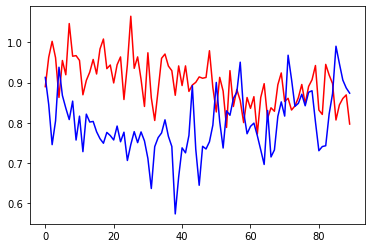

[TRAIN]  Epoch [35/50]   Loss: 36.3338
Loss decreased, saving model!
{'Error': {0: 10.627983093261719, 1: 11.69633674621582, 2: 9.390108108520508, 3: 7.859622001647949, 4: 0.5872142314910889, 5: 7.484637260437012, 6: 6.002147197723389, 7: 0.9407864809036255, 8: 9.283365249633789, 9: 2.7925360202789307, 10: 6.835173606872559, 11: 19.320171356201172, 12: 15.604920387268066, 13: 13.97441291809082, 14: 9.25680160522461, 15: 16.629474639892578, 16: 6.0458664894104, 17: 4.3700079917907715, 18: 13.61361312866211, 19: 3.2891125679016113, 20: 14.954689025878906, 21: 6.9134907722473145, 22: 15.629233360290527, 23: 11.615049362182617, 24: 7.040861129760742, 25: 2.0873494148254395, 26: 13.36922836303711, 27: 10.16853141784668, 28: 10.264082908630371, 29: 18.60122299194336, 30: 1.7618643045425415, 31: 8.796720504760742, 32: 22.246349334716797, 33: 21.165122985839844, 34: 9.941389083862305, 35: 1.7672630548477173, 36: 5.054382801055908, 37: 8.784019470214844, 38: 7.082507610321045, 39: 10.9330673217

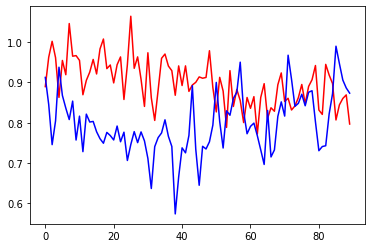

[TRAIN]  Epoch [36/50]   Loss: 36.3322
Loss decreased, saving model!
{'Error': {0: 10.626158714294434, 1: 11.694953918457031, 2: 9.389892578125, 3: 7.861053943634033, 4: 0.5891920328140259, 5: 7.483166694641113, 6: 6.000367164611816, 7: 0.9411827921867371, 8: 9.28283405303955, 9: 2.7929093837738037, 10: 6.836559772491455, 11: 19.318269729614258, 12: 15.603415489196777, 13: 13.973541259765625, 14: 9.256364822387695, 15: 16.628494262695312, 16: 6.045851230621338, 17: 4.369340419769287, 18: 13.6126127243042, 19: 3.289613962173462, 20: 14.953458786010742, 21: 6.913305282592773, 22: 15.629606246948242, 23: 11.613547325134277, 24: 7.041109561920166, 25: 2.0884785652160645, 26: 13.368914604187012, 27: 10.168949127197266, 28: 10.262982368469238, 29: 18.599464416503906, 30: 1.7622284889221191, 31: 8.79515552520752, 32: 22.243967056274414, 33: 21.1639461517334, 34: 9.94214153289795, 35: 1.7662041187286377, 36: 5.054528713226318, 37: 8.783751487731934, 38: 7.081781387329102, 39: 10.93353748321533

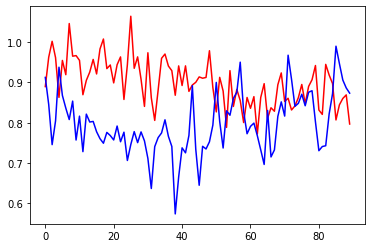

[TRAIN]  Epoch [37/50]   Loss: 36.3314
Loss decreased, saving model!
{'Error': {0: 10.624381065368652, 1: 11.693557739257812, 2: 9.389650344848633, 3: 7.862526893615723, 4: 0.5912150144577026, 5: 7.481657028198242, 6: 5.998544216156006, 7: 0.9415948987007141, 8: 9.282264709472656, 9: 2.7933096885681152, 10: 6.837985038757324, 11: 19.31637191772461, 12: 15.601910591125488, 13: 13.972650527954102, 14: 9.255928993225098, 15: 16.62750816345215, 16: 6.045843601226807, 17: 4.368710517883301, 18: 13.611580848693848, 19: 3.2901220321655273, 20: 14.952275276184082, 21: 6.9131293296813965, 22: 15.62996768951416, 23: 11.61201000213623, 24: 7.0413498878479, 25: 2.089578628540039, 26: 13.368569374084473, 27: 10.169374465942383, 28: 10.261825561523438, 29: 18.597688674926758, 30: 1.7626163959503174, 31: 8.793558120727539, 32: 22.241573333740234, 33: 21.16278648376465, 34: 9.942867279052734, 35: 1.7650631666183472, 36: 5.054651737213135, 37: 8.783462524414062, 38: 7.081026077270508, 39: 10.9340553283

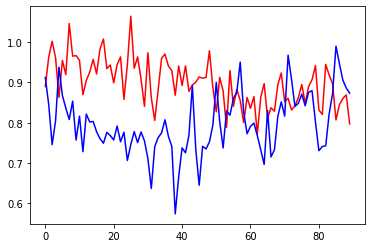

[TRAIN]  Epoch [38/50]   Loss: 36.3305
Loss decreased, saving model!
{'Error': {0: 10.623441696166992, 1: 11.692825317382812, 2: 9.389541625976562, 3: 7.863282203674316, 4: 0.5922452807426453, 5: 7.480891227722168, 6: 5.997622966766357, 7: 0.9417533874511719, 8: 9.281970024108887, 9: 2.7935023307800293, 10: 6.8386993408203125, 11: 19.315404891967773, 12: 15.601112365722656, 13: 13.972213745117188, 14: 9.255721092224121, 15: 16.626956939697266, 16: 6.045791149139404, 17: 4.368371963500977, 18: 13.611064910888672, 19: 3.290386199951172, 20: 14.951658248901367, 21: 6.913029193878174, 22: 15.630146980285645, 23: 11.611217498779297, 24: 7.0414886474609375, 25: 2.0901403427124023, 26: 13.368396759033203, 27: 10.169597625732422, 28: 10.261277198791504, 29: 18.596765518188477, 30: 1.762773036956787, 31: 8.792783737182617, 32: 22.24032974243164, 33: 21.162195205688477, 34: 9.943228721618652, 35: 1.76453697681427, 36: 5.054701805114746, 37: 8.783308029174805, 38: 7.080634593963623, 39: 10.934307

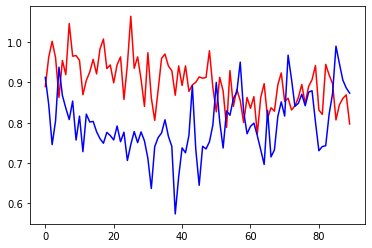

[TRAIN]  Epoch [39/50]   Loss: 36.3301
Loss decreased, saving model!
{'Error': {0: 10.62256145477295, 1: 11.692107200622559, 2: 9.389383316040039, 3: 7.864047527313232, 4: 0.59328693151474, 5: 7.480087757110596, 6: 5.9966654777526855, 7: 0.9419023990631104, 8: 9.28164291381836, 9: 2.79369854927063, 10: 6.839442253112793, 11: 19.31438636779785, 12: 15.60032844543457, 13: 13.971726417541504, 14: 9.255448341369629, 15: 16.626436233520508, 16: 6.0457611083984375, 17: 4.368039608001709, 18: 13.61052131652832, 19: 3.2906606197357178, 20: 14.951004028320312, 21: 6.912905693054199, 22: 15.630284309387207, 23: 11.610433578491211, 24: 7.0416340827941895, 25: 2.0906665325164795, 26: 13.368188858032227, 27: 10.169784545898438, 28: 10.260696411132812, 29: 18.59587287902832, 30: 1.7629297971725464, 31: 8.791980743408203, 32: 22.239103317260742, 33: 21.16155242919922, 34: 9.94356632232666, 35: 1.7640239000320435, 36: 5.054736137390137, 37: 8.783123016357422, 38: 7.080219745635986, 39: 10.934562683105

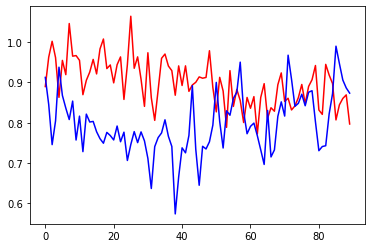

[TRAIN]  Epoch [40/50]   Loss: 36.3297
Loss decreased, saving model!
{'Error': {0: 10.621639251708984, 1: 11.691374778747559, 2: 9.389229774475098, 3: 7.864823341369629, 4: 0.5943172574043274, 5: 7.479322910308838, 6: 5.99573278427124, 7: 0.942127525806427, 8: 9.281347274780273, 9: 2.793933391571045, 10: 6.840162754058838, 11: 19.313396453857422, 12: 15.599575996398926, 13: 13.971264839172363, 14: 9.255209922790527, 15: 16.625913619995117, 16: 6.045712471008301, 17: 4.367719650268555, 18: 13.609930992126465, 19: 3.2909183502197266, 20: 14.950372695922852, 21: 6.912736415863037, 22: 15.630431175231934, 23: 11.609597206115723, 24: 7.04178524017334, 25: 2.091251850128174, 26: 13.36797046661377, 27: 10.169989585876465, 28: 10.260106086730957, 29: 18.594989776611328, 30: 1.7630983591079712, 31: 8.791145324707031, 32: 22.237869262695312, 33: 21.160884857177734, 34: 9.943914413452148, 35: 1.763474702835083, 36: 5.0548095703125, 37: 8.782925605773926, 38: 7.079824924468994, 39: 10.934787750244

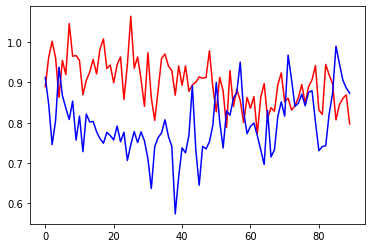

[TRAIN]  Epoch [41/50]   Loss: 36.3293
Loss decreased, saving model!
{'Error': {0: 10.62120532989502, 1: 11.691009521484375, 2: 9.389120101928711, 3: 7.865182876586914, 4: 0.5948795676231384, 5: 7.47890567779541, 6: 5.995265007019043, 7: 0.942168653011322, 8: 9.281161308288574, 9: 2.7940526008605957, 10: 6.840517997741699, 11: 19.312915802001953, 12: 15.599166870117188, 13: 13.9710111618042, 14: 9.255059242248535, 15: 16.625646591186523, 16: 6.04567813873291, 17: 4.3675408363342285, 18: 13.609661102294922, 19: 3.2910385131835938, 20: 14.9500150680542, 21: 6.912688732147217, 22: 15.63051986694336, 23: 11.609204292297363, 24: 7.041884899139404, 25: 2.091517925262451, 26: 13.367879867553711, 27: 10.170083045959473, 28: 10.259828567504883, 29: 18.594524383544922, 30: 1.7631686925888062, 31: 8.79073429107666, 32: 22.23721694946289, 33: 21.160566329956055, 34: 9.944144248962402, 35: 1.7632067203521729, 36: 5.0548553466796875, 37: 8.782837867736816, 38: 7.079615592956543, 39: 10.9349298477172

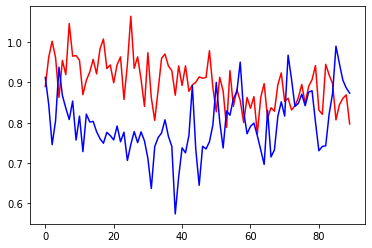

[TRAIN]  Epoch [42/50]   Loss: 36.3291
Loss decreased, saving model!
{'Error': {0: 10.620748519897461, 1: 11.690633773803711, 2: 9.38907241821289, 3: 7.865569114685059, 4: 0.5954041481018066, 5: 7.478529930114746, 6: 5.994782447814941, 7: 0.9422416090965271, 8: 9.281009674072266, 9: 2.794156551361084, 10: 6.840906143188477, 11: 19.312389373779297, 12: 15.598760604858398, 13: 13.97077465057373, 14: 9.254929542541504, 15: 16.625354766845703, 16: 6.045689582824707, 17: 4.367393493652344, 18: 13.609414100646973, 19: 3.2911930084228516, 20: 14.949697494506836, 21: 6.912630081176758, 22: 15.630619049072266, 23: 11.608783721923828, 24: 7.04191255569458, 25: 2.091730833053589, 26: 13.367761611938477, 27: 10.17017936706543, 28: 10.25948715209961, 29: 18.594078063964844, 30: 1.7632471323013306, 31: 8.790303230285645, 32: 22.236568450927734, 33: 21.160242080688477, 34: 9.944289207458496, 35: 1.762977957725525, 36: 5.054862976074219, 37: 8.78274917602539, 38: 7.0793843269348145, 39: 10.93502044677

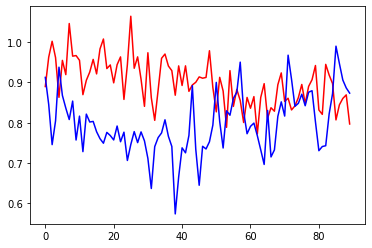

[TRAIN]  Epoch [43/50]   Loss: 36.3288
Loss decreased, saving model!
{'Error': {0: 10.620515823364258, 1: 11.69042682647705, 2: 9.389028549194336, 3: 7.865798473358154, 4: 0.59563809633255, 5: 7.47827672958374, 6: 5.99453067779541, 7: 0.942314624786377, 8: 9.280948638916016, 9: 2.794198989868164, 10: 6.841100215911865, 11: 19.31214141845703, 12: 15.598550796508789, 13: 13.970659255981445, 14: 9.254868507385254, 15: 16.62522315979004, 16: 6.045697212219238, 17: 4.367318153381348, 18: 13.609234809875488, 19: 3.2912545204162598, 20: 14.9495210647583, 21: 6.912626266479492, 22: 15.630680084228516, 23: 11.608550071716309, 24: 7.041998863220215, 25: 2.091937780380249, 26: 13.367718696594238, 27: 10.170219421386719, 28: 10.259357452392578, 29: 18.593786239624023, 30: 1.7632864713668823, 31: 8.790088653564453, 32: 22.23623275756836, 33: 21.16007423400879, 34: 9.944393157958984, 35: 1.7628178596496582, 36: 5.054878234863281, 37: 8.782694816589355, 38: 7.079283714294434, 39: 10.935097694396973, 

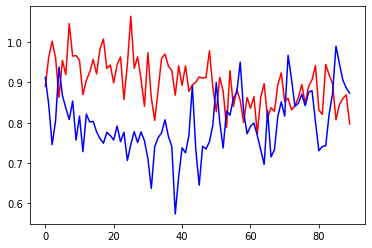

[TRAIN]  Epoch [44/50]   Loss: 36.3287
Loss decreased, saving model!
{'Error': {0: 10.620258331298828, 1: 11.690268516540527, 2: 9.38896656036377, 3: 7.865973472595215, 4: 0.5959249138832092, 5: 7.478085041046143, 6: 5.99424409866333, 7: 0.9423494338989258, 8: 9.280858039855957, 9: 2.794264316558838, 10: 6.84127140045166, 11: 19.311861038208008, 12: 15.598370552062988, 13: 13.970555305480957, 14: 9.254790306091309, 15: 16.625045776367188, 16: 6.045648574829102, 17: 4.367246627807617, 18: 13.609105110168457, 19: 3.2913129329681396, 20: 14.949350357055664, 21: 6.9125471115112305, 22: 15.630720138549805, 23: 11.608325004577637, 24: 7.042037010192871, 25: 2.09203839302063, 26: 13.367644309997559, 27: 10.170297622680664, 28: 10.259195327758789, 29: 18.593578338623047, 30: 1.7633529901504517, 31: 8.789867401123047, 32: 22.23592758178711, 33: 21.15989112854004, 34: 9.944489479064941, 35: 1.762683629989624, 36: 5.054874420166016, 37: 8.78264045715332, 38: 7.079195022583008, 39: 10.935169219970

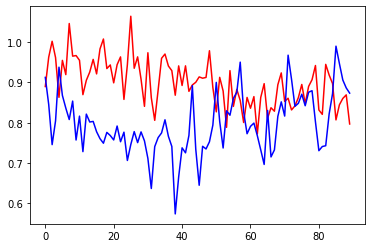

[TRAIN]  Epoch [45/50]   Loss: 36.3286
Loss decreased, saving model!
{'Error': {0: 10.620047569274902, 1: 11.690053939819336, 2: 9.388912200927734, 3: 7.866232872009277, 4: 0.5961853265762329, 5: 7.477876663208008, 6: 5.9940314292907715, 7: 0.9423272609710693, 8: 9.280762672424316, 9: 2.7943413257598877, 10: 6.84146785736084, 11: 19.311609268188477, 12: 15.598145484924316, 13: 13.970409393310547, 14: 9.254708290100098, 15: 16.624935150146484, 16: 6.045655727386475, 17: 4.367180347442627, 18: 13.608942985534668, 19: 3.291388511657715, 20: 14.949178695678711, 21: 6.91252326965332, 22: 15.630743980407715, 23: 11.608113288879395, 24: 7.04208517074585, 25: 2.0921802520751953, 26: 13.367597579956055, 27: 10.170324325561523, 28: 10.259027481079102, 29: 18.593334197998047, 30: 1.7633607387542725, 31: 8.789645195007324, 32: 22.23561668395996, 33: 21.159704208374023, 34: 9.94456672668457, 35: 1.7625693082809448, 36: 5.05491304397583, 37: 8.78260326385498, 38: 7.079061031341553, 39: 10.9352111816

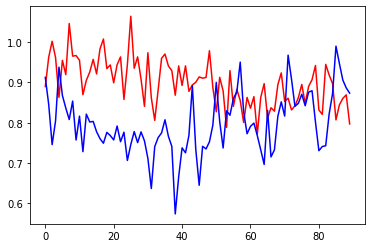

[TRAIN]  Epoch [46/50]   Loss: 36.3285
Loss decreased, saving model!
{'Error': {0: 10.619911193847656, 1: 11.68997859954834, 2: 9.388877868652344, 3: 7.866325378417969, 4: 0.5963136553764343, 5: 7.477791786193848, 6: 5.993867874145508, 7: 0.9423716068267822, 8: 9.280736923217773, 9: 2.794368267059326, 10: 6.841558933258057, 11: 19.311452865600586, 12: 15.598074913024902, 13: 13.970332145690918, 14: 9.25467300415039, 15: 16.624855041503906, 16: 6.04566764831543, 17: 4.367152214050293, 18: 13.608871459960938, 19: 3.291426658630371, 20: 14.94908618927002, 21: 6.91249942779541, 22: 15.630785942077637, 23: 11.607992172241211, 24: 7.04208517074585, 25: 2.0922627449035645, 26: 13.367587089538574, 27: 10.170356750488281, 28: 10.258966445922852, 29: 18.593236923217773, 30: 1.7633410692214966, 31: 8.789515495300293, 32: 22.2354793548584, 33: 21.159618377685547, 34: 9.944629669189453, 35: 1.7624942064285278, 36: 5.05491304397583, 37: 8.782569885253906, 38: 7.079006195068359, 39: 10.93526363372802

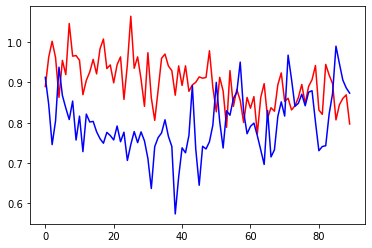

[TRAIN]  Epoch [47/50]   Loss: 36.3284
Loss decreased, saving model!
{'Error': {0: 10.61976432800293, 1: 11.68986988067627, 2: 9.388853073120117, 3: 7.866405010223389, 4: 0.5965136289596558, 5: 7.477685928344727, 6: 5.993743419647217, 7: 0.9423716068267822, 8: 9.280675888061523, 9: 2.794368267059326, 10: 6.841678142547607, 11: 19.311328887939453, 12: 15.597904205322266, 13: 13.970294952392578, 14: 9.254626274108887, 15: 16.624755859375, 16: 6.045655727386475, 17: 4.367105484008789, 18: 13.608776092529297, 19: 3.291457176208496, 20: 14.948986053466797, 21: 6.912509918212891, 22: 15.630777359008789, 23: 11.607887268066406, 24: 7.042126178741455, 25: 2.0923633575439453, 26: 13.367562294006348, 27: 10.17037296295166, 28: 10.258886337280273, 29: 18.59309196472168, 30: 1.7633920907974243, 31: 8.789406776428223, 32: 22.235300064086914, 33: 21.159528732299805, 34: 9.944696426391602, 35: 1.7624059915542603, 36: 5.054920673370361, 37: 8.782548904418945, 38: 7.078951835632324, 39: 10.935278892517

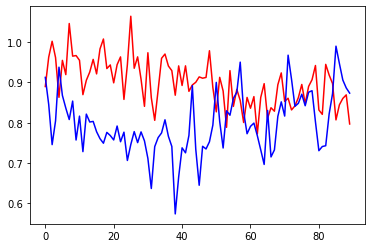

[TRAIN]  Epoch [48/50]   Loss: 36.3284
Loss decreased, saving model!
{'Error': {0: 10.619733810424805, 1: 11.689821243286133, 2: 9.38884162902832, 3: 7.866471290588379, 4: 0.5965702533721924, 5: 7.477630615234375, 6: 5.99370813369751, 7: 0.9424095749855042, 8: 9.280660629272461, 9: 2.794379949569702, 10: 6.841713905334473, 11: 19.311264038085938, 12: 15.59788990020752, 13: 13.970252990722656, 14: 9.254615783691406, 15: 16.624736785888672, 16: 6.045644283294678, 17: 4.367086410522461, 18: 13.608759880065918, 19: 3.2914438247680664, 20: 14.94896411895752, 21: 6.912502765655518, 22: 15.630805969238281, 23: 11.607843399047852, 24: 7.042129993438721, 25: 2.0923988819122314, 26: 13.367551803588867, 27: 10.170379638671875, 28: 10.258879661560059, 29: 18.593042373657227, 30: 1.7633960247039795, 31: 8.789374351501465, 32: 22.235219955444336, 33: 21.159488677978516, 34: 9.944709777832031, 35: 1.7623666524887085, 36: 5.054928302764893, 37: 8.782526969909668, 38: 7.0789313316345215, 39: 10.9352788

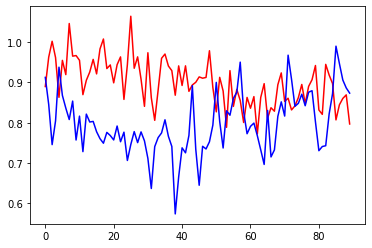

[TRAIN]  Epoch [49/50]   Loss: 36.3284
Loss decreased, saving model!
{'Error': {0: 10.6196870803833, 1: 11.689772605895996, 2: 9.388833999633789, 3: 7.866500377655029, 4: 0.5966155529022217, 5: 7.47760009765625, 6: 5.993637561798096, 7: 0.9423874616622925, 8: 9.280655860900879, 9: 2.794379949569702, 10: 6.8417558670043945, 11: 19.311220169067383, 12: 15.597846984863281, 13: 13.970242500305176, 14: 9.254615783691406, 15: 16.624698638916016, 16: 6.045637130737305, 17: 4.367074012756348, 18: 13.608741760253906, 19: 3.2914540767669678, 20: 14.948953628540039, 21: 6.912516117095947, 22: 15.63080883026123, 23: 11.607796669006348, 24: 7.042122840881348, 25: 2.092416763305664, 26: 13.367548942565918, 27: 10.170400619506836, 28: 10.258848190307617, 29: 18.592981338500977, 30: 1.763384222984314, 31: 8.789326667785645, 32: 22.235166549682617, 33: 21.159454345703125, 34: 9.94474983215332, 35: 1.7623437643051147, 36: 5.054905414581299, 37: 8.782514572143555, 38: 7.078897953033447, 39: 10.9353046417

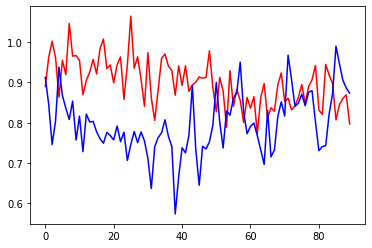

[TRAIN]  Epoch [50/50]   Loss: 36.3284
Loss decreased, saving model!
{'Error': {0: 10.619660377502441, 1: 11.689772605895996, 2: 9.388827323913574, 3: 7.866560459136963, 4: 0.596698522567749, 5: 7.47757625579834, 6: 5.993587970733643, 7: 0.9424095749855042, 8: 9.280649185180664, 9: 2.7943954467773438, 10: 6.841765403747559, 11: 19.311195373535156, 12: 15.59780502319336, 13: 13.970229148864746, 14: 9.254595756530762, 15: 16.624670028686523, 16: 6.045640468597412, 17: 4.367045879364014, 18: 13.608712196350098, 19: 3.2914743423461914, 20: 14.948904037475586, 21: 6.912502765655518, 22: 15.630820274353027, 23: 11.607784271240234, 24: 7.042133808135986, 25: 2.0924460887908936, 26: 13.367548942565918, 27: 10.170403480529785, 28: 10.258833885192871, 29: 18.592937469482422, 30: 1.7633686065673828, 31: 8.789298057556152, 32: 22.23509407043457, 33: 21.1594295501709, 34: 9.94473648071289, 35: 1.7623013257980347, 36: 5.054886341094971, 37: 8.782514572143555, 38: 7.078871726989746, 39: 10.9353256225

In [37]:
tr.train_epochs()